# Implementation of Hierarchical Dirichlet Processes in Python

#### By Andrew Carr and Eduardo Coronado
##### STA 663, Duke University, Spring 2020
##### April 30th, 2020
</br> 

##### Github repo: https://github.com/datadiarist/hdp 
##### (installation instructions found on README)

</br>

## Abstract

In this report, we implement a Hierarchical Dirichlet Process (HDP) algorithm in Python based on Yee Why Teh et al's 2005 methods paper. The algorithm uses the Chinese Restaurant Franchise construction for its implementation. Further, code optimization was sought to improve the inference and text preprocessing speeds. Optimization tasks achieved a 30-40% reduction in run-time compared to initial versions of the algorithm. A set of 622 scientific paper abstracts were used infer topics with the HPD algorithm and performance was assessed via a perplexity score. Further, the algorithm was compared to existing package implementations in `gensim` and similar methods such as Latent Dirichlet Allocation (LDA).  Results from a comparison of perplexity scores indicate that our algorithm performs comparably well to Gensim's LDA when trained on an optimal number of topics.

## Background

The following paper aims to describe the mathematical basis of Hierarchical Dirichlet Processes (HDPs) for topic modeling and its implementation in Python. This based on Yee Whye Teh et al’s 2005 methods paper carrying the same name and builds upon some methods described below.$^1$ 


### i) Topic Modeling

Before diving into details on HDP, it is helpful to provide some general background on topic modeling and related methods.  Topic modeling refers to the set of unsupervised techniques used to analyze text data in documents (corpus) and determine clusters of words (topics). These methods are commonly implemented in settings requiring grouping documents based on text similarity or exploring non-apparent trends in text data. For example, auto-tagging customer support tickets based the textual similarity to previous tickets or gathering underlying trends from open-ended questions in customer feedback that could inform product features. Therefore, common results from topic modeling include 1) a set of topics and 2) a set of documents grouped by topics. However, it is important to note that these methods treat text data in a bag-of-words representation which ignores syntactic and semantic information. Similarly, they require lots of high-quality data (i.e. pre-cleaned text) for them to be most effective. 
<br>

To understand HPDs, it is important to start with a general understanding of base topic modeling algorithms such as Latent Semantic Analysis (LSA) and Latent Dirichlet Allocation (LDA).$^{2,3}$ These methods have two main underlying assumptions when it comes to modeling text. The first is that similar topics will use similar words (i.e. each topic will have a distribution over words), and the second is that documents talk about multiple topics (i.e. document can be thought as a mixture of topics). However, there exists one main difference between LSA and LDA. LSA doesn’t assume topics are distributed according to a specific distribution, while LDA offers a probabilistic approach and assumes the topics are Dirichlet distributed. 

Below is a plate representation of an LDA model. Here $D$ is a set of documents and $N$ is the number of words within each document. The main idea is that for each document $d$ we have a set of topics ($\theta_d$) and we assigns topics($z_{d,n}$) to those words ($w_{d,n}$). The parameter $\alpha$ controls how many topics are assigned to documents, while $\eta$ controls how many words are assigned to topic

<figure>
    <img src="imgs/lda_plate.png" alt="Drawing" style="display: block;margin-left: auto;margin-right: auto;width: 50%;"/>
    <figcaption style="text-align: center;">LDA plate model. <i> Source: D. Blei (Columbia, 2012)</i></figcaption>
</figure>

However, the main disadvantage of either of these models is their parametric nature, that is, that the number of clusters (i.e. mixture components) has to be defined. As a result, non-parametric methods such as Dirichlet Process Mixtures were developed to overcome this limitation.

### ii) Dirichlet Process Mixtures

Dirichlet Process Mixtures (DPMs) can be thought of as an extension to LDA in that, instead of predefining topics, these are inferred from the data (non-parametric) and can be thought as coming from an infinite distribution of topics. This last statement is only possible due thanks to something called Dirichlet Processes (DPs). 

#### Dirichlet Processes (DPs)

Formally, a DP is defined as a distribution over distributions and is made up of a countably infinite number of point masses.

In simpler terms, this generates a discrete distribution that is considered "infinite". This infinitely discrete property arises from first generating samples from a continuous base distribution (e.g. a Gaussian), which can take an infinite number of forms, before these are realized as discrete when we assign weights to these samples. The result is an infinitely discrete distribution that follows a Dirichlet distribution.

For example, the diagram below shows $G$ (light blue) samples generated via a Dirichlet Process with parameters $\alpha$ (think about this as weights) and $G_0$ (a continuous base distribution, e.g. a Gaussian). In other words, the $G$ is made up of "countably infinite" samples generated from weighted Gaussian samples from $G_0$ (red) and weights defined by $\alpha$.
<br><br>

<figure>
    <img src="imgs/dp.png" alt="Drawing" style="display: block;margin-left: auto;margin-right: auto;width: 65%;"/>
    <figcaption style="text-align: center;">Dirichlet Process representation. <i> Source: K. El-Arini (2008)</i></figcaption>
</figure>
<br>

In topic modeling the Dirichlet Process is used to generate an infinite discrete distribution of topics. 
<br><br>

#### Dirichlet Process Mixtures (DPMs)

A common, and sometimes helpful analogy, to DPMs is that of a Chinese Restaurant Process. We imagine a restaurant that serves dishes (topics) from an infinite menu (set of topics) and has space for infinite tables (word clusters). Each table can only be served one dish from the menu, but dishes can be repeated among tables. Customers (words) are then seated with certain probability on either an occupied or a new table. The diagram below shows a depiction of this process. The parameter $\phi_{k,t}$ on each table represents a topic-table ($k,t$ are topic and table indexes), and the customers represent the words. When a new customer (word) appears, it seated in either on a new or existing table. These decision are based on probabilities proportional to number of seated customers per table ($N$), overall customers seated, and the concentration parameter $\alpha$. 


<figure>
    <img src="imgs/crp.png" alt="Drawing" style="display: block;margin-left: auto;margin-right: auto;width: 50%;"/>
    <figcaption style="text-align: center;">Chinese Restaurant Process. <i> Source: Eric P. Xing (2014)</i></figcaption>
</figure>

The process is complete once all customers are seated (i.e. all words have been assigned to a cluster) and we can interpret the topics from the words in clusters sharing the topic (dish).

But what if we had multiple document collections (groups) – say a group on statistics and another one on computer engineering - and wanted these groups to share information/topics in our model? The current set-up wouldn’t allow for these collections to share the same infinite number of topics given each DP would generate an independent mixture for each corpora. Here’s where the hierarchical property of HDP comes into play.


### iii) Hierarchical Dirichlet Process (HDP)

As its name states HDPs builds upon DPMs using a hierarchy, in that, they provide an infinite number of topics that can now be shared amongst different corpora (document groups). For a quick comparison, the images below depict the differences between DPMs and HDPs. First, the DPMs diagram below shows how although two groups sample from the same continuous base distribution $H$ (left), they don't share the same Dirichlet Process distribution (right) with infinite number of topics.


<figure>
    <img src="imgs/DPM_2.png" alt="Drawing" style="display: block;margin-left: auto;margin-right: auto;width: 70%;"/>
    <figcaption style="text-align: center; padding-left:10%; padding-right:10%;"> <b>Dirichlet Process Mixtures</b>: (left) plate diagram representing DPM for two sets of documents, (right) samples from distinct DPM for each group. <i> Source: Teh et al (2007)</i></figcaption>
</figure>

<br><br>
In comparison, the HDP diagram below shows how introducing a hierarchy allows both groups to sample from the same Dirichlet Process distribution with infinite topics (here noted as $G_0$).


<figure>
    <img src="imgs/HDP_2.png" alt="Drawing" style="display: block;margin-left: auto;margin-right: auto;width: 70%;"/>
    <figcaption style="text-align: center; padding-left:10%; padding-right:10%;"> <b>Hierarchical Dirichlet Process </b>: (left) plate diagram representing HDP for two sets of documents now sharing an infinite number of topics $G_0$, (right) samples from shared $G_0$ for each group. <i> Source: Teh et al (2007)</i></figcaption>
</figure>


We can continue with the Chinese Restaurant Process analogy and represent HDPs as a Chinese Restaurant Franchise. The only difference will be that there are multiple restaurants (document groups) that now share dishes from one global infinite menu ($G_0$). The process is similar to that of the Chinese Restaurant Process in that once words have been assigned to a cluster and we can interpret the topics. However, this time these topics are shared amongs topics.

## Algorithm

The algorithm presented in this paper implements a Hierarchical Dirichlet Process to infer topics from a set of documents using a Chinese Restaurant Franchise scheme given this representation allows for straightforward Gibbs (MCMC) sampler.

First, given text data as input, some preprocessing steps are used to extract a common vocabulary and relevant words to each document. These include word stemming, tokenization, stop word removal and frequency filtering.
Next, the Chinese Restaurant Franchise framework is used to infer the topics shared across documents. These are then interpreted from words grouped in each topic cluster. 

At a high-level the process involves the following:
1. looping through each document,
2. looping through each word in a document, and 
3. probabilistically assigning these words to a topic cluster


This process is repeated for multiple epochs (1 epoch = 1 loop through all documents) to gain some convergence on the words in each cluster. The topics can then be interpreted based on the words within each topic cluster
The processes described are explained in detail below


### i) Pre-processing

Given a set of document text data in a single-column CSV, each observation (i.e. row) was preprocessed using the following five steps:

1. Remove punctuations and lemmatize words to return the dictionary format of each word
2. Remove stopwords and short words (i.e. length <= 3)
3. Build a term-frequency (tf) matrix based on the aggregate vocabulary (i.e. all unique words in all documents)
4. Filter out low and high frequency words (i.e. those appearing in either < 3 documents or more than half of the documents)
5. Assign a unique word identified and build a nested list, where each document is a sublist with unique word identifiers representing the words in that document


### ii) Inference

As described at a high-level the Background section, HDPs can be represented via a Chinese Restaurant Franchise metaphor. Now, to be more specific, restaurants correspond to document groups $j$ and customers/words $i$ correspond to factors $\theta_{ji}$. Topics from the global menu are denoted by $K$ iid random variables $\phi_1,…,\phi_K$, and $\psi_{jt}$ represent a table-specific topic choice at table $t$ in document $j$.

It is important to know that there is a specific correspondence between the $\theta$s, $\psi$s, and $\phi$s; specifically, each $\theta_{ji}$ is associated with one $\psi_{jt}$ and one $\psi_{jt}$ is associated with one $\phi_k$ as shown in the diagram below.
<br> <br>

<figure>
    <img src="imgs/crp_teh.png" alt="Drawing" style="display: block;margin-left: auto;margin-right: auto;width: 40%;"/>
    <figcaption style="text-align: center; padding-left:10%; padding-right:10%;"> <b>Chinese Restaurant Franchise</b>: Rectangles represent the restaurants and the circles the tables in each restaurant. Customers are represented as $\theta_{ji}$ and seated on a table with a $\psi_{jt}$ (table-specific topic choice) which is defined by $\phi_k$ <i> Source: Teh et al (2006)</i></figcaption>
</figure>


<br><br>
However, we can simplify these associations using indexes. Let $t_{ji}$ be the index associating the $\theta_{ji}$ and $\psi_{jt}$, and $k_{jt}$ be the index associating the $\psi_{jt}$ and $\phi_k$. Thus, in the metaphor customer $i$ in restaurant $j$ sits at table $t_{ji}$  and table $t$ in restaurant $j$ serves dish/topic $k_{jt}$.

Without these indexes, the MCMC would need to infer $\theta_{ji}$s and $\psi_{jt}$s from their respective posterior distributions. 

Instead, the simplified representation makes the MCMC sampling for efficient while keeping properties from the original associations needed to infer the topics. Now, we sample the index variables $t_{ji}$ and $k_{jt}$ using adapted versions of the $\theta_{ji}$ and $\psi_{jt}$ posteriors.




#### a) Sampling pseudocode

The following pseudocode provides a general overview of the sampling steps. Before, diving into the specifics of each sampling step additional notation will be provided within the metaphor within the franchise metaphor.

<figure>
    <img src="imgs/pseudo-code.png" alt="Drawing" style="display: block;margin-left: auto;margin-right: auto;width: 60%;"/>
</figure>





#### b) Relevant Notation

Let $j$ index the restaurant (document), $i$ index the customer (word), $k$  index the dish (topic), and $t$ index the table. Let $n$ denote customer-related counts and $m$ table-related counts, and marginal counts be represented with dots. 

Thus, $n_{jtk}$ is the number of customers in restaurant $j$ at table $t$ eating dish $k$, and $n_{jt\cdot}$ is the overall number of customers in restaurant $j$ at table $t$.

In terms of table-related counts, $m_{jk}$ denotes the number of tables in restaurant $j$ serving dish $k$, and thus $m_{j\cdot}$ is the number of tables in restaurant $j$, $m_{\cdot k}$ is the number of overall tables serving dish $k$ and $m_{\cdot \cdot}$ be the number of overall occupied tables.

We use boldface variables to represent sets. 
For example $\mathbf{x}_{jt}$ = ( $x_{ji}$: all $i$ with $t_{ji} = t$), $\mathbf{t}$ = ($t_{ji}$: all $j,i$), and $\mathbf{k}$ = ($k_{jt}$: all $j,t$).Let $\mathbf{x}$ represent the observed data, and $x_{ji}$ be the $i$ observation/customer in restaurant $j$.  

Superscripts attached to variables or counts means the variable removed from the set or count (e.g. $x^{-ji} = \mathbf{x} \setminus x_{ji}$). As an example $n_{jt\cdot}^{-ji}$ is the number of customers in restaurant $j$ seated in table $t$ excluding customer $x_{ji}$.

Given this notation, we now move to the specifics of sampling the indexes $\mathbf{t}$ and $\mathbf{k}$.


#### c) Sampling <b>t</b>
    
For each word $x_{ji}$, we first construct a set of posterior probabilities using the conditional posterior of $t_{ji}$ that combines the prior distribution of $t_{ji}$ and the likelihood of generating $x_{ji}$ with the following piecewise function
    
$$p(t_{ji} = t \mid \textbf{t}^{-ji}, \textbf{k}) =   \left\{
\begin{array}{ll}
      n_{jt \cdot}^{-ji}\; f_{k_{jt}}^{-x_{ji}}(x_{ji}) & \text{if } t \text{  previously used} \\
      \alpha_0\; p(x_{ji} \mid \textbf{t}^{-ji}, t_{ji} = t^{new}, \textbf{k}) & \text{if } t = t^{new} \\
\end{array} 
\right.$$
    
which then are used to obtain a posterior sample of $t$ from a categorical distribution. 
    
<u><b>Intuitively</b></u>, we sample a new table  index with a probability proportional to $\alpha_0$ or a previously used one based on the number of $x$'s already assigned to that table.
<br><br>


Specifically,  <b>for a previously used</b> $t$ the likelihood  $f_{k}^{-x_{ji}}(x_{ji})$ is generated from  conditional density of observation $x_{ji}$ under mixture component $k$ given all other observations except $x_{ji}$ and formally defined as

$$f_{k}^{-x_{ji}}(x_{ji}) = \frac{\int f(x_{ji} \mid \phi_k) \prod_{j'i' \neq ji, z_{j'i'} = k}f(x_{j'i'}\mid\phi_k)h(\phi_k) d\phi_k }{\int \prod_{j'i' \neq ji, z_{j'i'} = k}f(x_{j'i'}\mid\phi_k)h(\phi_k) d\phi_k }$$

with the sampling $f(\cdot \mid \phi_k)$ and prior  $h(\cdot)$ being conjugated as follows - $h(\cdot) \sim Dir(0.5)$ a symmetric Dirichlet and $f(\cdot \mid \phi_k) \sim Cat(\mathbf{\phi})$ a categorical distribution. 

<b>For a  new t </b> ($t = t^{new}$) the likelihood is generated via $p(x_{ji} \mid \textbf{t}^{-ji}, t_{ji} = t^{new}, \textbf{k})$ where we integrate out the possible values of $k_{jt^{new}}$ and then multiplied by the document group the concentration parameter $\alpha_0$ which defines the number of topics per document

$$p(x_{ji} \mid \textbf{t}^{-ji}, t_{ji} = t^{new}, \textbf{k}) = \sum_{k=1}^K \frac{m_{\cdot k}}{m_{\cdot\cdot} + \gamma} f_{k}^{-x_{ji}}(x_{ji}) + \frac{\gamma}{m_{\cdot\cdot} + \gamma} f_{k^{new}}^{-x_{ji}}(x_{ji}) $$

where $f_{k^{new}}^{-x_{ji}}(x_{ji}) = \int f(x_{ji} \mid \phi) h(\phi) d\phi $ is the prior density of $x_{ji}$ and $\gamma$ is the topic concentration parameter of the base distribution H.

<b>Now, if the sampled $t$ is <u> NEW </u> </b> then we must find wheter this new table index ($t^{new}$) should be associated with either an existing topic or a new topic ($k_{jt^{new}})$. Thus, we construct the posterior probabilities of $k_{jt^{new}}$ using the following piecewise function and then sample a new value of $k$ from a categorical distribution.

$$p(k_{jt^{new}} = k \mid \textbf{t},\textbf{k}^{-jt^{new}}) =   \left\{
\begin{array}{ll}
      m_{\cdot k}\; f_{k_{jt}}^{-x_{ji}}(x_{ji}) & \text{if } k \text{  previously used} \\
      \gamma\; f_{k^{new}}^{-x_{ji}}(x_{ji}) & \text{if } k = k^{new} \\
\end{array} 
\right.$$

with $f_{k^{new}}^{-x_{ji}}(x_{ji}$ and $\gamma$ having the same definitions as before.

<u><b>Intuitively</b></u>, we sample a new table topic index with a probability proportional to $\gamma$ or a previously used one based on the number of tables already associated with that topic.
<br>

As a result of updating $t_{ji}$ some table might become unoccupied $n_{jt\cdot}$, so it is removed because there is a probability 0 that this table will be occupied in the future.  We delete a specific table-topic component $k_{jt}$ as a consequence of deleting this table $t$, which in turn might leave a topic component $k$ unallocated. If that is the case, this component $k$ is deleted as well.
<br><br>



#### d) Sampling <b>k</b>

For each table in document $j$, we sample a new table topic $k_{jt}$ from a categorical distribution based on the posterior probabilities generated from the following piecewise function. 

$$p(k_{jt^{new}} = k \mid \textbf{t},\textbf{k}^{-jt}) =   \left\{
\begin{array}{ll}
      m_{\cdot k}\; f_{k_{jt}}^{-\textbf{x}_{ji}}(\textbf{x}_{ji}) & \text{if } k \text{  previously used} \\
      \gamma\; f_{k^{new}}^{-\textbf{x}_{ji}}(\textbf{x}_{ji}) & \text{if } k = k^{new} \\
\end{array} 
\right.$$


Since changing $k_{jt}$ changes the associations of all data items $x{ji}$ in that table, we slightly modify the likelihood $f_{k}^{-x_{ji}}(x_{ji})$ as follows - replace $x_{ji}$ with $\mathbf{x}_{jt}$ given we want to condition based all data related to that topic except the ones in table $t$.

The intuition is similar to that of sampling a new topic in the previous section, but now considers a larger range of data points when computing the posterior probabilities. Again, if updating any table-topic component $k_{jt}$ leaves a topic component $k$ unallocated then this component is deleted.


## Optimization

Data preprocessing and HDP inference scripts were initially developed using plain python to understand what would be the baseline performance of the scripts without any optimizations. This code was stored separately in two python scripts named `text_prep.py` and `HDP_baseline.py`. 

To understand the bottlenecks of our code we timed and profiled each script using a test set composed of 622 paper abstracts. Various methods were used including magics such as `timeit` and `prune`, and the `cython` profiler to understand which areas could turned into C++ code. The average run-time speed for the `text_prep.py` script was about 2.5 seconds, while the inference script `HDP_baseline.py` was 2.6 seconds on  Mac OS (4CPUs, 16 Gb RAM).

#### Optimizing `text_prep.py`

The script's goals was to preprocess the abstract text data and produce a data structure ready-to-use for the inference functions as described on the previous section. The output structure would be a set of lists, each for a document, containing the words from the shared vocabulary appearing on each document. To simplify the inference, words from the vocabulary were coded with unique ids. 

After profiling the script, most time was spent on the lemmatization and stemming steps using the `nltk` package, followed by the word frequency and filtering processes to generate the shared vocabulary and inference-ready data structure. Given the steps for lemmatization/stemming are involved and the `nltk` package provides easy-to-use methods, we focused our optimization on the second most time consuming processing - constructing word frequencies, filtering and generating the data objects required for inference.

These processes were optimized with custom C++ code `hdp_preproc.cpp` that leveraged `STL` containers and `Eigen` C++ library, and used `pybind11` to wrap it for Python use. We first optimized the word frequency and filtering methods, followed by some optimizations on text preprocessing steps (e.g. removing punctuations). 

The custom functions were tested and the profiled to understand the performance gain. <b>On average these optimizations reduced the text preprocessing time by 30% compared to the straightforward script</b>  as seen below. The optimized script was stored as `text_prep_optim.py`.

In [1]:
import os

if not os.path.exists('eigen'):
    ! git clone  https://gitlab.com/libeigen/eigen.git
        

In [2]:
import text_prep
import text_prep_optim

In [8]:
%timeit -r3 -n3 text_prep.run_preprocess("../data/tm_test_data.csv")

2.66 s ± 277 ms per loop (mean ± std. dev. of 3 runs, 3 loops each)


In [9]:
%timeit -r3 -n3 text_prep_optim.run_preprocess_optim("../data/tm_test_data.csv")

1.95 s ± 60.1 ms per loop (mean ± std. dev. of 3 runs, 3 loops each)


#### Optimizing `HDP_baseline.py`

This script implements the pseudo-code presented on the previous section and outputs inferences on topics, counts and words groupings found in the input text data. After profiling the script, most of the time was spent sampling from the posterior distributions for both `k` and `t` as well as obtaining posterior multinomial random samples. 

Therefore, we first optimized the `sample_t` and `sample_k` functions using C++ custom code `hdp_funcs.cpp`. These again leveraged `STL` containers and the `Eigen` to improve speeds. The largest increase in speed came from the `sample_k` function since it required to computes the explicit posterior for a Dirichlet-Multinomial distribution. Similarly, the `numpy` multinomial random sampling was optimized with custom C++ code based on a conditional binomial sampling method referenced in the `GNU` scientific library package.

Overall, <b>these optimizations reduced the inference run-time by 40% on average </b> compared to the straighforward python script as shown below. The optimized script was stored as `HDP_optimized.py`.

In [72]:
import HDP_baseline
import HDP_optimized
import numpy as np

vocab, docs = text_prep_optim.run_preprocess_optim("../data/tm_test_data.csv")

# Hyper params
np.random.seed(7)
beta = 0.5 # word concentration (LDA)
alpha = 0.8 # GP hyperparam (tuned, can use np.random.gamma(1,1) alternatively)
gamma = 10 # Base GP hyperparam (tuned, can use np.random.gamma(1,1) alternatively)


In [6]:
%timeit -r3 -n3 HDP_baseline.hdp(docs, vocab, gamma, alpha, beta, epochs=1)

2.74 s ± 69.4 ms per loop (mean ± std. dev. of 3 runs, 3 loops each)


In [7]:
%timeit -r3 -n3 HDP_optimized.hdp_optimized(docs, vocab, gamma, alpha, beta, epochs=1)

1.42 s ± 56.5 ms per loop (mean ± std. dev. of 3 runs, 3 loops each)


# Model Evaluation - Testing on real data

One popular way to evaluate the fit of a topic model, both for hierarchical topic models and for standard topic models where the number of topics is set as a hyperparameter, is by measuring the perplexity of the model on a given data set.  Topic model perplexity evaluates the fit of a model using two distributions returned by the model: the distribution of words across topics and the distribution of topics within documents.  Namely, if the likelihood of a word being assigned to a given topic is high, and the probability that that topic will appear within a document is also high, this will improve the fit of the model according to the perplexity metric.  Perplexity is positive number that indicates better fit through smaller values and is defined by the following equation.

$$P = \frac{-\sum_{i=1}^{M} \log p(w)}{N}$$

In this equation, $M$ denotes the number of documents in the corpus, $p(w)$ is a probability distribution produced from the document-topic and word-topic distributions, and $N$ is the total numbber of terms across documents.  We created our own function to measure topic model perplexity, perplex_func, which is called from the perplexity script in the code below. 

### Gensim LDA

The Gensim package offers a broad range of tools for topic modeling.  We ran Gensim's topic model on real data: a set of 622 abstracts from several math and science journals.  This dataset has been used in the past in R topic modeling package vignettes, so our expectation is that Gensim will find distinct topics in the data.    

To begin, we modified the corpus and vocabulary so that they are in a format that is compatible is Gensim. This entailed converting the numeric document index back into strings and applying functions from Gensim's Dictionary module to this.

In [5]:
import perplexity
from gensim.corpora.dictionary import Dictionary
from gensim.models import LdaModel
from gensim.test.utils import common_corpus
from gensim.corpora.dictionary import Dictionary

# Create list of words in each document from doc index and vocabulary
docs_words = perplexity.back_to_words(docs, vocab)

# Create a formatted corpus and dictionary from a list of texts
common_dictionary = Dictionary(docs_words)
common_corpus = [common_dictionary.doc2bow(text) for text in docs_words]

# Manual corpus key (for ensuring that document-word indices match vocab key)
corpus_key = []
for i in common_corpus:
    corpus_key.append([j[0] for j in i])

Next, we trained 15 standard, non-hierarchical topic models on the data.  For each model, the number of topics (a hyperparameter in standard LDA) was set between 1 and 15.  The output of each model was then converted to a set of word-topic and document-topic distributions using the model_to_dist function from the perplexity script.  We used these distributions to compute the perplexity of the models with varying numbers of topics.

In [4]:
# Storing perplexity scores for Gensim's LDA fitted with varying numbers of topics  
perplex_lst = []
for i in range(1,15):
    topic_num = i
    lda = LdaModel(common_corpus, num_topics=topic_num)
    doc_topic_dist, word_topic_dist = perplexity.model_to_dist(lda, common_corpus, common_dictionary, topic_num)
    perp = perplexity.perplex_func(doc_topic_dist, word_topic_dist, corpus_key)
    perplex_lst.append((i,perp))

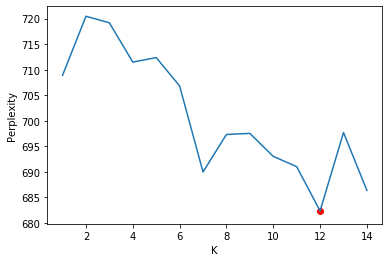

In [5]:
import matplotlib.pyplot as plt

fig = plt.figure()
ax1 = fig.add_subplot()
ax1.set_ylabel('Perplexity')
ax1.set_xlabel('K')

plt.plot([i[0] for i in perplex_lst], [i[1] for i in perplex_lst])
plt.scatter([j[0] for j in perplex_lst if j[1] == min([i[1] for i in perplex_lst])], 
            min([i[1] for i in perplex_lst]), c = 'r')
pass

The plot above displays the relationship between the perplexity score of each model and the number of topics hyperparameter given to that model.  We tried using random.seed to ensure that the models produced consistent results.  However, we found that model output for both Gensim's LDA and our algorithm varied even with random seeding.  The figure above will therefore vary slightly every time this notebook is run.  The model with best fit (i.e. minimum perplexity) generally has been 10 and 14 topics and a perplexity score of about 675.  Scores ranged between 675 and 830.  

### Hierarchical LDA with HDP

Next, we run our hierarchical LDA algorithm on the same data and use the functions from the perplexity module to evaluate the performance of our algorithm.

First, we ran the algorithm several times, varying each model by the number of epochs used to train the model.  We converted the output of our algorithm to data structures that our perplexity function can accommodate and stored word-topic and document-topic distributions in a list.

In [73]:
import pandas as pd 

dist_stuff = []

for i in range(1, 10):

    # Running HDP with varying numbers of iterations
    doc_arrays, topic_idx, n_kv, m_k = HDP_optimized.hdp_optimized(docs, vocab, gamma, alpha, beta, epochs=i)

    doc_dist = perplexity.doc_arrays_to_doc_topic_distribution(doc_arrays, topic_idx)
    word_dist = perplexity.n_kv_to_word_dist(n_kv, topic_idx)
    
    # Storing distributions in list
    dist_stuff.append((doc_dist, word_dist))

Next, we computed perplexity of the model train on 1 to 9 epochs and stored these perplexity scores.  We plotted the relationship between perplexity and number of iterations below.

In [74]:
perplex_hdp = []
for i in range(9):
    perplex_hdp.append(perplexity.perplex_func(dist_stuff[i][0], dist_stuff[i][1], docs))

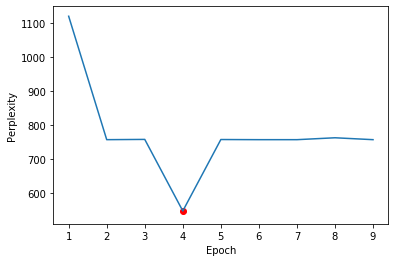

In [75]:
import matplotlib.pyplot as plt

fig = plt.figure()
ax1 = fig.add_subplot()
ax1.set_ylabel('Perplexity')
ax1.set_xlabel('Epoch')

plt.plot(range(1, 10), perplex_hdp)
plt.scatter(np.where(np.array(perplex_hdp) == min(perplex_hdp))[0][0]+1, min(perplex_hdp), color = 'r')

plt.show()

This figure indicates that our algorithm achieves a best fit of the data quickly, usually after a few iterations or even only a single iteration.  Interestingly, the model does not converge on a best fit of the data at each successive iteration, which is what we expected would happen.  We think that this could be due either to incompatibilities between the functions in the perplexity module and the output of our model or issues with how our model removes topics or tables after several iterations.  Still, the model performs comparably Gensim's LDA with optimum K, with a lowest perplexity score in the mid-700s.

### Testing HDP on Simulated Data

So far, we have shown that our algorithm does comparably to Gensim's LDA (with optimal k) at fitting a topic model to a set of documents.   Specifically, Gensim and HDP both yield scores in the 700s on the test data.  To give the reader a frame of reference for understanding these numbers, we ran the model on some simulated data.  For this simulation, we produced a set of numbers to represent a vocabulary.  We then sampled from this vocabulary, with replacement, to produce a set of documents that represent texts with words randomly distributed across them.  Document lengths were constrained to vary from 100 to 400 words, and we produced 622 (same as real data) documents total.  There is no underlying structure in this simulated texts and any differences in how often pairs of words co-occur across these texts is  random.  Therefore, they should have a higher perplexity score than the scores we estimated above for the real data in which texts were organized around an underlying topic structure.

In [17]:
# Vocabulary of 1000 words  
vocab_sim = list(range(1000))

In [18]:
import random
random.seed(123)

doc_length = random.randint(100,400)

docs_sim = []

for j in range(622):
    docs_sim.append([random.randint(1, 1000) for i in range(doc_length)])

In [22]:
import perplexity

dist_sim = []

for i in range(1, 10):

    # Running HDP with varying numbers of iterations
    doc_arrays_sim, topic_idx_sim, n_kv_sim, m_k_sim = HDP_baseline.hdp(docs_sim, vocab, gamma, alpha, beta, epochs=i)

    doc_dist_sim = perplexity.doc_arrays_to_doc_topic_distribution(doc_arrays_sim, topic_idx_sim)
    word_dist_sim = perplexity.n_kv_to_word_dist(n_kv_sim, topic_idx_sim)
    
    # Storing distributions in list
    dist_sim.append((doc_dist_sim, word_dist_sim))

In [23]:
perplex_hdp_sim = []
for i in range(9):
    perplex_hdp_sim.append(perplexity.perplex_func(dist_sim[i][0], dist_sim[i][1], docs_sim))

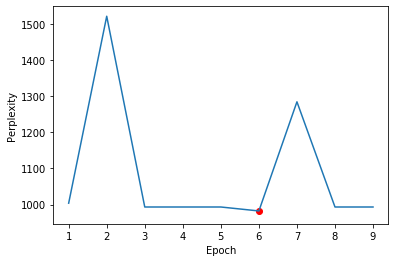

In [24]:
import matplotlib.pyplot as plt

fig = plt.figure()
ax1 = fig.add_subplot()
ax1.set_ylabel('Perplexity')
ax1.set_xlabel('Epoch')

plt.plot(range(1, 10), perplex_hdp_sim)
plt.scatter(np.where(np.array(perplex_hdp_sim) == min(perplex_hdp_sim))[0][0]+1, min(perplex_hdp_sim), color = 'r')

plt.show()

This figure indicates that the model did not achieve a perplexity score below 950 for any of the iterations.  This is what we expected to find: the model finds no underlying structure in the data.  This also indicates that our HDP is working - when trained on a corpus of documents that vary meaningfully by the structure of the words they contain,  HDP fits the data well.

## Discussion/conclusion

We learned several things from evaluating the results of our algorithm, both my comparing them to output of Gensim's LDA model and by making comparisons between real and simulated data.  First, we found Gensim's output to fit the data with similar accuracy to the output from our model.  This provides evidence that the algorithm works as intended.  Also, we compared the fit of this model to the relatively poor fit of the model on simulated data, in which words were randomly distributed across topics.  This gave a frame of reference through which to understand the other perplexity scores.  On random data, the model results had a perplexity score in the 1000s.  On a real corpus with an underlying topic structure, the output of both Gensim's model and our model had perplexity scores in the high 600s or 700s.

Further analysis is needed to understand why our model isn't converging on a particular perplexity score.  Relatedly, our model did not converge on a consistent optimal number of topics when run on this data.  This may be due to the stochastic nature of hierarchical LDA, or to the fact that we had not trained the data for a sufficient number of epochs.

## Resources

1. Yee Whye Teh, Michael I Jordan, Matthew J Beal & David M Blei (2006) Hierarchical Dirichlet Processes, Journal of the American Statistical Association, 101:476, 1566-1581, DOI: 10.1198/016214506000000302

2. Blei, David M., Andrew Y. Ng, and Michael I. Jordan (2003). Latent dirichlet allocation. Journal of machine Learning research 3.Jan, 993-1022.

3. Dumais, S. T., Furnas, G. W., Landauer, T. K., & Deerwester, S. (1988). Using latent semantic analysis to improve information retrieval. Proceedings of CHI'88 Conference on Human Factors in Computing Systems, 281–285.

4. Khalid El-Arini (2008). Dirichlet Processes: A gentle introduction. Carnegie Mellon University, Computer Science.

5. Eric P. Xing. Hierarchical Dirichlet Processes. 10-708: Probabilistic Graphical Models 10-708, Spring 2014. Scribe Notes.

## Author Contributions
Both authors contributed equally to the development of this project.